# Include Librarie(s)

In [13]:
import os
import pandas as pd
import numpy as np
import json

# Plotting
import matplotlib.pyplot as plt

# Load Data From CSV File

The following function will load the data from the CSV file and return a pandas dataframe.

In [14]:
def load_csi_matrix_from_file(csv_path: str):
    """
    从解析好的csv文件中读取csi矩阵，矩阵通常是一个 3 x 3 x 114 的矩阵
    Load csi matrix from the parsed csv file, the matrix is usually a 3 x 3 x 114 matrix

    @param csv_path: the path of the csv file

    @return: the csi matrix
    """

    # 验证，若csv文件不存在，则返回一个Null值
    # if the csv file does not exist, return a Null value
    if not os.path.isfile(csv_path):
        print("The csv file is not valid!")
        return None

    # 读取csv矩阵
    # read the csv matrix
    csi_pd = pd.read_csv(csv_path, sep='\t', encoding='utf-8')

    # 将CSV中的数据帧转换为CSI矩阵，这样得到数据矩阵维度就会变成 n x 3 x 3 x 114 x 2
    # Convert the data frame in the CSV to a CSI matrix, so that the dimension of the data matrix will become n x 3 x 3 x 114 x 2
    csi_matrix = csi_pd['csi_matrix']
    csi_matrix = [csi_matrix_str for csi_matrix_str in csi_matrix]  # 我们是以JSON字符串的形式存储的CSI矩阵
    csi_matrix = [np.array(json.loads(csi_matrix_str)) for csi_matrix_str in csi_matrix]  # 将JSON字符串转换为CSI矩阵
    # csi_matrix = [csi[:, :, :, 0] + 1j * csi[:, :, :, 1] for csi in csi_matrix]  # 将CSI矩阵转换为复数矩阵

    # 将转换后的CSI矩阵，重新赋值给csi_pd
    # Assign the converted CSI matrix to csi_pd
    csi_pd['csi_matrix'] = csi_matrix

    return csi_pd

Due to the uncertainty of our collection environment, the collected data contains a certain amount of uncertainty. Since the collection program faithfully records all data, it will also be reflected in the CSV data. So before we process the data further, the data needs to be cleaned.

In [15]:
def assess_data_cleanliness(csi_pd):
    
    # 这里，我们要开始检查数据维度的统一性
    # Here, we are going to start checking the uniformity of data dimensions
    csi_matrix = csi_pd['csi_matrix']

    # 首先，我们统计数据中出现的维度，并对其进行排序
    # First, we count the dimensions that appear in the data and sort them
    dimension_set = set()

    for csi in csi_matrix:
        dimension_set.add(csi.shape)

    dimension_list = list(dimension_set)
    dimension_list.sort()

    # 然后，我们统计每个维度出现的次数
    # Then, we count the number of occurrences of each dimension
    dimension_count = [0 for i in range(len(dimension_list))]
    
    for csi in csi_matrix:
        dimension_count[dimension_list.index(csi.shape)] += 1
    
    total_count = sum(dimension_count)

    # 最后，我们输出统计结果
    # Finally, we output the statistical results
    print("The number of different dimensions in the data is: ", len(dimension_list))
    print("The dimensions that appear in the data are: ", dimension_list)
    print("The number of occurrences of each dimension is: ", dimension_count)
    print("The percentage of each dimension is: ", [str(int(count / total_count * 10000) / 100) + "%" for count in dimension_count])

    return dimension_list, dimension_count

Then we need to eliminate all data whose dimension_count is not the maximum value. Of course, we will rewrite this part of the code in the future after we figure out how to fix this part of the data.

In [16]:
def data_cleaning(csi_pd, dimension_list, dimension_count):

    # 找出dimension_count里最大的一项，并找出其对应的dimension_list的索引
    # Find the largest item in dimension_count and find the index of its corresponding dimension_list
    max_dimension_index = dimension_count.index(max(dimension_count))

    # 找出dimension_list里最大的一项，并找出其对应的dimension_count的索引
    # Find the largest item in dimension_list and find the index of its corresponding dimension_count
    max_dimension = dimension_list[max_dimension_index]

    # 保留最大的dimension_list里最大的一项，其余的全部删除
    # Keep the largest item in the largest dimension_list, and delete the rest
    csi_pd = csi_pd[csi_pd['csi_matrix'].map(lambda csi: csi.shape == max_dimension)]

    return csi_pd

The following is the test data

In [17]:
# 测试用数据
# Test data
csi_pd = load_csi_matrix_from_file(r"C:\Users\Seagosoft\Downloads\202309130935\csi.csv")

# 检查数据维度的统一性
# Check the uniformity of data dimensions
dimension_list, dimension_count = assess_data_cleanliness(csi_pd)

# 数据清洗
# Data cleaning
csi_pd = data_cleaning(csi_pd, dimension_list, dimension_count)

# 检查数据维度的统一性
# Check the uniformity of data dimensions
print('---------------------------After data cleaning---------------------------')
dimension_list, dimension_count = assess_data_cleanliness(csi_pd)

The number of different dimensions in the data is:  2
The dimensions that appear in the data are:  [(56, 2, 3, 2), (56, 3, 3, 2)]
The number of occurrences of each dimension is:  [2836, 9790]
The percentage of each dimension is:  ['22.46%', '77.53%']
---------------------------After data cleaning---------------------------
The number of different dimensions in the data is:  1
The dimensions that appear in the data are:  [(56, 3, 3, 2)]
The number of occurrences of each dimension is:  [9790]
The percentage of each dimension is:  ['100.0%']


# Data Processing

Now we try to extract the phase and amplitude from the signal.

In [18]:
# 从试验数据中测试以上函数
# Test the above functions from the experimental data
csi_frame = csi_pd['csi_matrix'][0]

## How to calculate the amplittude of a complex array

To calculate the amplitude of a one-dimensional array of complex numbers, we first need to understand what the amplitude of a complex number is. for a complex number $z = a + bi$, the amplitude of $|z|$ is defined as:

$$|z| =\sqrt{a^2 + b^2}$$

In [19]:
def extract_amplitude(csi_frame):
    """
    从CSI矩阵中提取振幅信息
    Extract amplitude information from CSI matrix

    @param csi_frame_matrix: CSI matrix
    @return: amplitude matrix
    """

    # 计算a^2 + b^2
    # Calculate a^2 + b^2
    temp = csi_frame[:, :, :, 0] ** 2 + csi_frame[:, :, :, 1] ** 2

    # 提取振幅信息 sqrt(a^2 + b^2)
    # Extract amplitude information sqrt(a^2 + b^2)
    temp = np.sqrt(temp)

    return temp

### Test the function

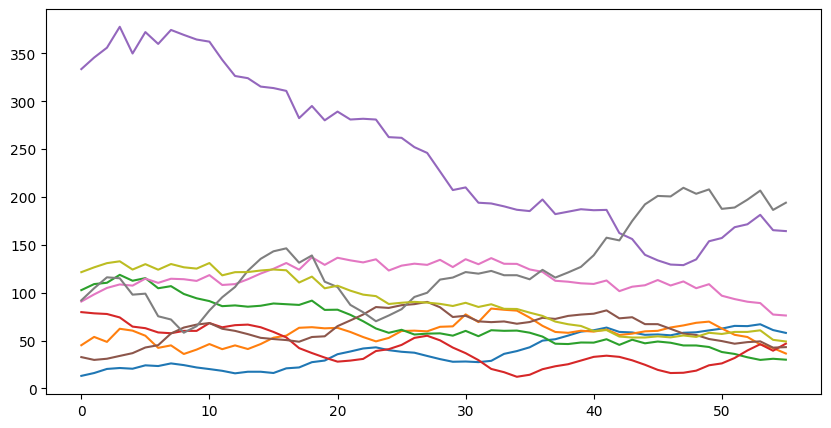

In [20]:
# 绘制未处理的CSI图像
# Draw unprocessed CSI image
csi_frame_amplitude = extract_amplitude(csi_frame)

# 将 tones x ntx x nrx 的矩阵转换为 signals x tones 的矩阵
# Convert the tones x ntx x nrx matrix to the signals x tones matrix
csi_frame_amplitude = csi_frame_amplitude.reshape((csi_frame_amplitude.shape[0], -1))

# 绘制CSI曲线图
# Draw CSI curve
plt.figure(figsize=(10, 5))
plt.plot(csi_frame_amplitude)
plt.show()

### Test the function

## How to calculate the dB of a complex array

The dB of a complex number is defined as:

$$dB = 20\log_{10}{|z|}$$

In [21]:
def extract_dB(csi_abs_frame):
    """
    从CSI矩阵中提取dB信息

    @param csi_abs_frame: CSI matrix
    @return: dB matrix
    """

    csi_abs_frame += 1e-10
    csi_abs_frame = 20 * np.log10(csi_abs_frame)
    return csi_abs_frame

### Test the function

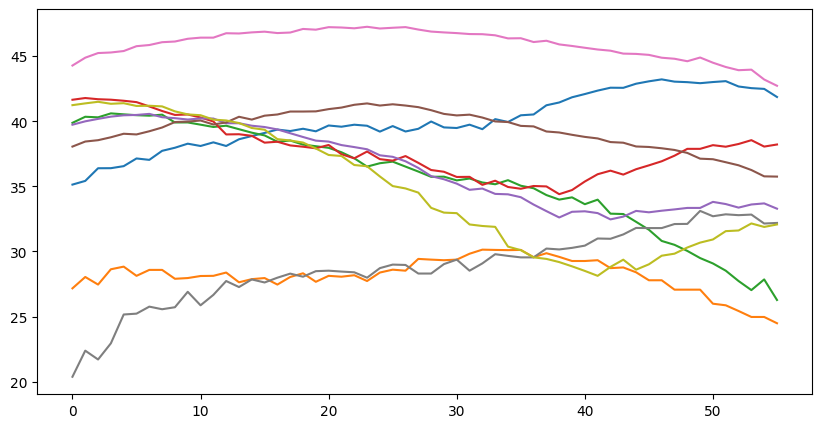

In [22]:
# 从试验数据中测试以上函数
# Test the above functions from the experimental data
csi_frame = csi_pd['csi_matrix'][100]

# 绘制未处理的CSI图像
# Draw unprocessed CSI image
csi_frame_amplitude = extract_amplitude(csi_frame)

# 将 tones x ntx x nrx 的矩阵转换为 signals x tones 的矩阵
# Convert the tones x ntx x nrx matrix to the signals x tones matrix
csi_frame_amplitude = csi_frame_amplitude.reshape((csi_frame_amplitude.shape[0], -1))

# 计算dB值
# Calculate dB value
csi_frame_amplitude = extract_dB(csi_frame_amplitude)

# 绘制CSI曲线图
# Draw CSI curve
plt.figure(figsize=(10, 5))
plt.plot(csi_frame_amplitude)
plt.show()

## How to calcuate the phase of a complex array

The phase of a complex number is defined as:

$$\theta = \arctan{\frac{b}{a}}$$

In [23]:
def extract_phase(csi_frame):
    """
    从CSI矩阵中提取相位信息
    Extract phase information from CSI matrix

    @param csi_frame_matrix: CSI matrix
    @return: phase matrix
    """

    # 计算 b/a 的值
    # Calculate the value of b/a
    temp = csi_frame[:, :, :, 1] / (csi_frame[:, :, :, 0] + 1e-10)

    # 提取相位信息 arctan(b/a)
    # Extract phase information arctan(b/a)
    temp = np.arctan(temp)

    return temp

### Test the function

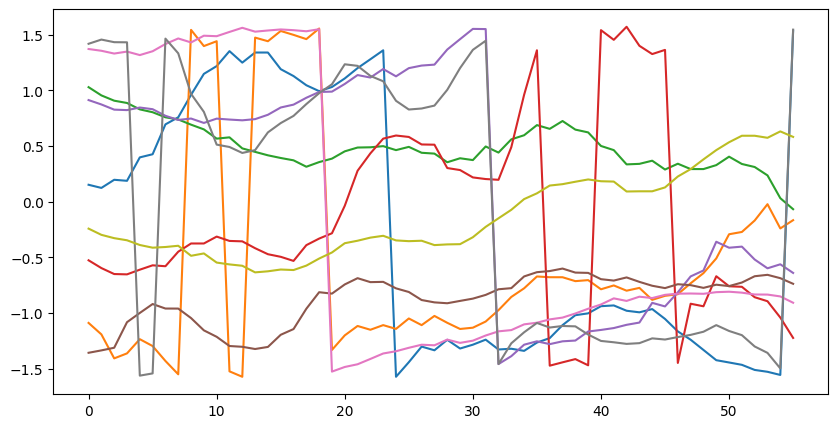

In [24]:
# 从试验数据中测试以上函数
# Test the above functions from the experimental data
csi_frame = csi_pd['csi_matrix'][0]

# 计算相位信息
# Calculate phase information
csi_frame_phase = extract_phase(csi_frame)

# 将 tones x ntx x nrx 的矩阵转换为 signals x tones 的矩阵
# Convert the tones x ntx x nrx matrix to the signals x tones matrix
csi_frame_phase = csi_frame_phase.reshape((csi_frame_phase.shape[0], -1))

# 绘制CSI曲线图
# Draw CSI curve
plt.figure(figsize=(10, 5))
plt.plot(csi_frame_phase)
plt.show()